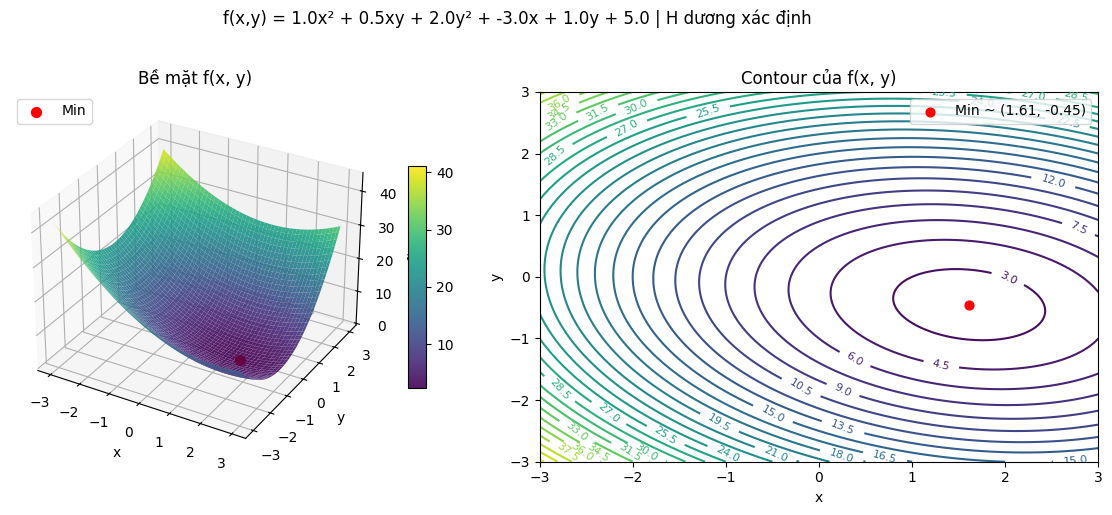

In [1]:
# Ví dụ hàm bậc 2 với 2 biến X = (x, y)
# f(x, y) = a x^2 + b x y + c y^2 + d x + e y + f0

import numpy as np
import matplotlib.pyplot as plt

# Định nghĩa hệ số (có thể thay đổi để thử nghiệm)
a, b, c = 1.0, 0.5, 2.0
d, e, f0 = -3.0, 1.0, 5.0


def quadratic_2vars(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return a * x**2 + b * x * y + c * y**2 + d * x + e * y + f0


# Tạo lưới điểm để vẽ
x_vals = np.linspace(-3, 3, 200)
y_vals = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = quadratic_2vars(X, Y)

# Tính điểm cực tiểu (nếu ma trận Hessian dương xác định)
# Grad f = [2a x + b y + d, b x + 2c y + e] = 0
# => [[2a, b], [b, 2c]] [x, y]^T = -[d, e]^T
H = np.array([[2 * a, b], [b, 2 * c]], dtype=float)
g = np.array([d, e], dtype=float)

# Kiểm tra tính xác định dương của Hessian
is_pos_def = np.all(np.linalg.eigvals(H) > 0)

if np.linalg.det(H) != 0:
    xy_star = -np.linalg.solve(H, g)
    x_star, y_star = xy_star
    f_star = quadratic_2vars(x_star, y_star)
else:
    x_star = y_star = f_star = np.nan

# Vẽ 3D surface và contour
fig = plt.figure(figsize=(12, 5))

# 3D surface
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
surf = ax1.plot_surface(X, Y, Z, cmap="viridis", alpha=0.9, linewidth=0, antialiased=True)
ax1.set_title("Bề mặt f(x, y)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("f(x,y)")
fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=12)

# Đánh dấu điểm cực tiểu (nếu tồn tại)
if np.isfinite(x_star) and np.isfinite(y_star):
    ax1.scatter([x_star], [y_star], [f_star], c="red", s=50, label="Min")
    ax1.legend(loc="upper left")

# Contour (đường đồng mức)
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.contour(X, Y, Z, levels=30, cmap="viridis")
ax2.clabel(cs, inline=True, fontsize=8)
ax2.set_title("Contour của f(x, y)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

if np.isfinite(x_star) and np.isfinite(y_star):
    ax2.scatter([x_star], [y_star], c="red", s=40, label=f"Min ~ ({x_star:.2f}, {y_star:.2f})")
    ax2.legend(loc="upper right")

plt.suptitle(
    (
        f"f(x,y) = {a}x² + {b}xy + {c}y² + {d}x + {e}y + {f0} | "
        + ("H dương xác định" if is_pos_def else "H không dương xác định")
    ),
    y=1.02,
)
plt.tight_layout()
plt.show()



In [ ]:
# Tạo dataset giám sát (x, y) -> f(x, y)
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Thiết lập seed để tái lập
np.random.seed(42)
torch.manual_seed(42)

# Phạm vi lấy mẫu và số lượng mẫu
num_samples = 5000
xy_low, xy_high = -3.0, 3.0

xy = np.random.uniform(xy_low, xy_high, size=(num_samples, 2)).astype(np.float32)
x_np = xy[:, 0]
y_np = xy[:, 1]

z_np = quadratic_2vars(x_np, y_np).astype(np.float32)

# Chia train/test
train_ratio = 0.8
num_train = int(train_ratio * num_samples)
num_test = num_samples - num_train

X_tensor = torch.from_numpy(xy)  # shape [N, 2]
y_tensor = torch.from_numpy(z_np).unsqueeze(1)  # shape [N, 1]

dataset = TensorDataset(X_tensor, y_tensor)
train_ds, test_ds = random_split(dataset, [num_train, num_test])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

device = torch.device("cpu")
len(train_ds), len(test_ds)


In [ ]:
# Định nghĩa mô hình hồi quy đơn giản với PyTorch
import torch.nn as nn

class MLPRegressor(nn.Module):
    def __init__(self, in_features: int = 2, hidden_sizes=(32, 32)):
        super().__init__()
        layers = []
        last = in_features
        for h in hidden_sizes:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

model = MLPRegressor().to(device)
model


In [ ]:
# Huấn luyện mô hình
import math

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
log_every = 5

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_ds)

    if epoch % log_every == 0 or epoch == 1:
        # Tính loss trên tập test
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                test_loss += criterion(preds, yb).item() * xb.size(0)
            test_loss /= len(test_ds)
        print(f"Epoch {epoch:03d} | train MSE = {epoch_loss:.6f} | test MSE = {test_loss:.6f}")
"Huấn luyện xong"


In [ ]:
# Đánh giá mô hình: MSE trên test và dự đoán trên lưới để trực quan
model.eval()
with torch.no_grad():
    # MSE trên test set
    test_loss = 0.0
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        test_loss += criterion(preds, yb).item() * xb.size(0)
    test_loss /= len(test_ds)

print(f"Test MSE: {test_loss:.6f}")

# Dự đoán trên lưới để vẽ
X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)
XY_grid = np.hstack([X_flat, Y_flat]).astype(np.float32)
with torch.no_grad():
    Z_pred = model(torch.from_numpy(XY_grid).to(device)).cpu().numpy().reshape(X.shape)

Z_true = Z  # từ trước đã tính
Z_pred.shape, Z_true.shape
